<a href="https://colab.research.google.com/github/Abhisek910/Apziva-project/blob/main/Voice%20Cloning%20and%20Fake%20Audio%20Detection/Voice_Cloning_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Part 2: THE CLASSIFIER
To classify real and fake audio, the classifier will be tested on two form of audio data.

1) Real audio data VS. Cloned audio data.

2) Real audio data VS. Cloned audio data with removing the noise.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download mozillaorg/common-voice
!unzip /content/common-voice.zip

Streaming output truncated to the last 5000 lines.
  inflating: cv-valid-train/cv-valid-train/sample-190776.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190777.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190778.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190779.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190780.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190781.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190782.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190783.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190784.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190785.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190786.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190787.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190788.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190789.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190790.mp3  
  in

## CommonVoice Dataset:


Common Voice is part of Mozilla's initiative to help teach machines how real people speak. Common Voice is a corpus of speech data read by users on the Common Voice website (https://commonvoice.mozilla.org/), and based upon text from a number of public domain sources like user submitted blog posts, old books, movies, and other public speech corpora. Its primary purpose is to enable the training and testing of automatic speech recognition (ASR) systems.




In [5]:
import shutil
import librosa 
import os
import random
import pandas as pd
import numpy as np


In [9]:
files_list = []

for root, dirs, files in os.walk("/content/cv-other-test"):
  for file in files:
    if file.endswith(".mp3"):
      files_list.append(os.path.join(root, file))
  

# print the files list
filesToCopy = random.sample(files_list, 400)  
destPath ="/content/real_audio"

# iteraate over all random files and move them
for file in filesToCopy:
    shutil.move(file, destPath)

### 1) Real audio data VS. Cloned audio data

### Fake Audio

In [7]:
fake_files_list =os.listdir("/content/drive/MyDrive/Apziva Project/synthesizer_long_audio_version")
# Read them into pandas
fake_df = pd.DataFrame(fake_files_list)
fake_df=  fake_df.rename(columns = {0:"file"})
fake_df["real"] = 0
fake_df.file  =[f"/content/drive/MyDrive/Apziva Project/synthesizer_long_audio_version/{i}" for i in fake_df.file]
fake_df.head()

,file,real
0,/content/drive/MyDrive/Apziva Project/synthesi...,0
1,/content/drive/MyDrive/Apziva Project/synthesi...,0
2,/content/drive/MyDrive/Apziva Project/synthesi...,0
3,/content/drive/MyDrive/Apziva Project/synthesi...,0
4,/content/drive/MyDrive/Apziva Project/synthesi...,0


### Real audio

In [10]:
#list the files
real_file_list = os.listdir("/content/real_audio") 
#read them into pandas
real_df = pd.DataFrame(real_file_list)
# Renaming the column name to file
real_df = real_df.rename(columns={0:'file'})
real_df['real'] = 1
real_df.file = [f"/content/real_audio/{i}" for i in real_df.file]
real_df.head(2)

,file,real
0,/content/real_audio/sample-002347.mp3,1
1,/content/real_audio/sample-001311.mp3,1


In [11]:
real_df.shape, fake_df.shape

((400, 2), (336, 2))

In [12]:
df = pd.concat([real_df, fake_df], axis=0)
df.head()

,file,real
0,/content/real_audio/sample-002347.mp3,1
1,/content/real_audio/sample-001311.mp3,1
2,/content/real_audio/sample-002304.mp3,1
3,/content/real_audio/sample-000308.mp3,1
4,/content/real_audio/sample-002851.mp3,1


In [13]:
df = df.sample(frac=1).reset_index(drop=True)

### Splitting the datasets into train, test, Validation

In [14]:
from sklearn.model_selection import train_test_split
X = df[["file"]]
y  =df.real
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val  =train_test_split(X_train,y_train, test_size=0.1, random_state=42, shuffle=True)



In [15]:
print(f"X_train length is : {len(X_train)}, y_train length is: {len(y_train)}")
print(f"X_test length is : {len(X_test)}, y_train length is: {len(y_test)}")
print(f"X_train length is : {len(X_val)}, y_train length is: {len(y_val)}")

X_train length is : 595, y_train length is: 595
X_test length is : 74, y_train length is: 74
X_train length is : 67, y_train length is: 67


### Extracting features

In [16]:
def extract_features(files):
  """
  return mfccs, chroma, mel, contrast and tonnetz for each audio file
  """
  df = {'mfccs' : [], 'chroma' : [], 'mel' : [], 'contrast' : [], 'tonnetz' : []}
  for file_name in files:
    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    df['mfccs'].append(mfccs)
    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))
    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    df['chroma'].append(chroma)
    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    df['mel'].append(mel)
    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    df['contrast'].append(contrast)
    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    df['tonnetz'].append(tonnetz)
  return df

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
val_features = extract_features(X_val.file)
train_features =extract_features(X_train.file)
test_features =extract_features(X_test.file)

**Scaling all of the features and concatenate them into an array for each audio file**

In [19]:
from librosa.feature.spectral import tonnetz
from sklearn.preprocessing import StandardScaler
scaler =StandardScaler()


def concat_features(features):
  features_list = []
  for i in range(0, len(features["mfccs"])):
    features_list.append(np.concatenate((
        scaler.fit_transform((features["mfccs"][i]).reshape(-1,1)),
        scaler.fit_transform((features["chroma"][i]).reshape(-1,1)),
        scaler.fit_transform((features["mel"][i]).reshape(-1,1)),
        scaler.fit_transform((features["contrast"][i]).reshape(-1,1)),
        scaler.fit_transform((features["tonnetz"][i]).reshape(-1,1))), axis=0))
  return np.array(features_list).reshape(len(features["mfccs"]), 193)

In [20]:
X_val_data   = concat_features(val_features)
X_train_data = concat_features(train_features)
X_test_data  = concat_features(test_features)

In [21]:
y_train =np.array(y_train)
y_test  =np.array(y_test)
y_val   =np.array(y_val)

### Creating the model

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

# 1) create the model
model_1 = tf.keras.Sequential([
                             tf.keras.layers.Dense(units=50, input_shape=(193,), activation='relu'),
                             tf.keras.layers.Dense(units=50, activation='relu'),
                            #  tf.keras.layers.Dense(units=50, activation='relu'), 
                             tf.keras.layers.Dense(units=1, activation='sigmoid')])
# 2) compile the model
model_1.compile(loss='binary_crossentropy', metrics=tf.keras.metrics.AUC(), optimizer='adam')
# 3) fit the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [23]:
hist_1 = model_1.fit(X_train_data, y_train, validation_data=(X_val_data, y_val), epochs=2000, callbacks=[early_stop])

Epoch 1/2000
19/19 [==============================] - 4s 19ms/step - loss: 0.5378 - auc: 0.8240 - val_loss: 0.2385 - val_auc: 0.9908
Epoch 2/2000
19/19 [==============================] - 0s 5ms/step - loss: 0.1426 - auc: 0.9954 - val_loss: 0.0915 - val_auc: 0.9963
Epoch 3/2000
19/19 [==============================] - 0s 5ms/step - loss: 0.0634 - auc: 0.9987 - val_loss: 0.0629 - val_auc: 0.9982
Epoch 4/2000
19/19 [==============================] - 0s 5ms/step - loss: 0.0380 - auc: 0.9996 - val_loss: 0.0465 - val_auc: 0.9991
Epoch 5/2000
19/19 [==============================] - 0s 5ms/step - loss: 0.0265 - auc: 0.9998 - val_loss: 0.0392 - val_auc: 0.9991
Epoch 6/2000
19/19 [==============================] - 0s 5ms/step - loss: 0.0191 - auc: 1.0000 - val_loss: 0.0380 - val_auc: 0.9991
Epoch 7/2000
19/19 [==============================] - 0s 5ms/step - loss: 0.0156 - auc: 1.0000 - val_loss: 0.0286 - val_auc: 1.0000
Epoch 8/2000
19/19 [==============================] - 0s 6ms/step - loss: 0

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

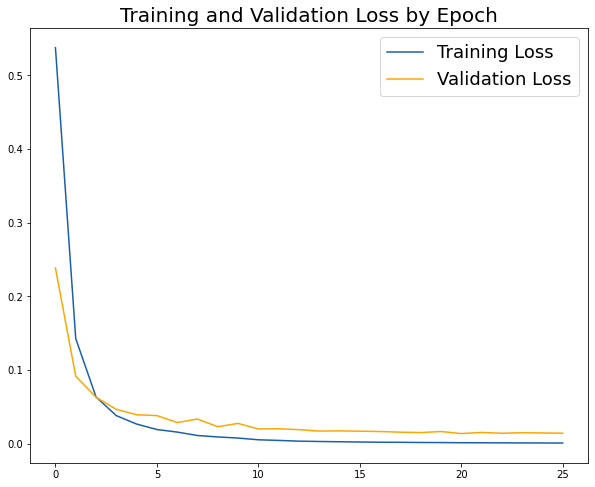

In [25]:
plt.figure(figsize=(10, 8))
# Generate line plot of training, testing loss over epochs.
plt.plot(hist_1.history['loss'], label='Training Loss', color='#185fad')
plt.plot(hist_1.history['val_loss'], label='Validation Loss', color='orange')
# Set title
plt.title('Training and Validation Loss by Epoch', fontsize = 20)
plt.legend(fontsize = 18);

3/3 [==============================] - 0s 6ms/step - loss: 0.0083 - auc: 1.0000
Test evaluation [0.008314544335007668, 1.0]


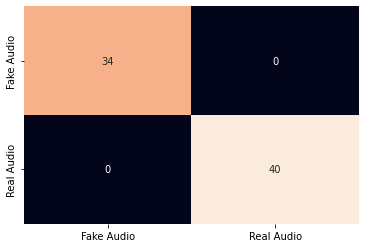

In [26]:
print("Test evaluation", model_1.evaluate(X_test_data, y_test))
cm= confusion_matrix(y_test, y_pred=tf.round(model_1.predict(X_test_data)))
ax =sns.heatmap(cm, annot=True, cbar=False)

# Ticker labels -list must be in alphabetical order
ax.xaxis.set_ticklabels(["Fake Audio", "Real Audio"])
ax.yaxis.set_ticklabels(["Fake Audio", "Real Audio"])

plt.show();

### 2) Real audio data VS. Cloned audio data with removing the noise.

In [27]:
pip install noisereduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
from scipy.io import wavfile
import noisereduce as nr

In [29]:
for file in os.listdir('/content/drive/MyDrive/Apziva Project/synthesizer_long_audio_version'):
  # load data
  rate, data = wavfile.read(f'/content/drive/MyDrive/Apziva Project/synthesizer_long_audio_version/{file}')
  # perform noise reduction
  reduced_noise = nr.reduce_noise(y=data, sr=rate)
  wavfile.write(f"/content/synthesizer_long_audio_version_without_noise/{file}", rate, reduced_noise)

In [30]:
#list the files
fake_file_list_without_noise = os.listdir('/content/synthesizer_long_audio_version_without_noise') 
#read them into pandas
fake_df_without_noise = pd.DataFrame(fake_file_list_without_noise)
# Renaming the column name to file
fake_df_without_noise = fake_df_without_noise.rename(columns={0:'file'})
fake_df_without_noise['real'] = 0
fake_df_without_noise.file = [f"/content/synthesizer_long_audio_version_without_noise/{i}" for i in fake_df_without_noise.file]
fake_df_without_noise.head(2)

,file,real
0,/content/synthesizer_long_audio_version_withou...,0
1,/content/synthesizer_long_audio_version_withou...,0


In [31]:
df_without_noise = pd.concat([real_df, fake_df_without_noise], axis=0)
df_without_noise = df_without_noise.sample(frac=1).reset_index(drop=True)
df_without_noise.head(2)

,file,real
0,/content/real_audio/sample-000259.mp3,1
1,/content/real_audio/sample-001686.mp3,1


In [32]:
X = df_without_noise[['file']]
y = df_without_noise.real
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=True)

In [33]:
print(f"X_train length is: {len(X_train)}, y_train length is: {len(y_train)}")
print(f"X_test length is: {len(X_test)}, y_test length is: {len(y_test)}")
print(f"X_val length is: {len(X_val)}, y_val length is: {len(y_val)}")

X_train length is: 595, y_train length is: 595
X_test length is: 74, y_test length is: 74
X_val length is: 67, y_val length is: 67


In [34]:
val_features = extract_features(X_val.file)
train_features = extract_features(X_train.file)
test_features = extract_features(X_test.file)

In [35]:
X_val_data = concat_features(val_features)
X_train_data = concat_features(train_features)
X_test_data = concat_features(test_features)

In [36]:
from IPython.display import Audio

tf.random.set_seed(42)

model_2 =tf.keras.Sequential([
                              tf.keras.layers.Dense(units=193, input_shape=(193,),activation="relu"),
                              tf.keras.layers.Dense(units=50, activation="relu"),
                              tf.keras.layers.Dense(units=1, activation="sigmoid")
])


model_2.compile(loss="binary_crossentropy",
                metrics=tf.keras.metrics.AUC(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001))


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [38]:
hist_3 = model_2.fit(X_train_data, y_train, validation_data=(X_val_data, y_val), epochs=1000, callbacks=[early_stop])

Epoch 1/1000
19/19 [==============================] - 1s 18ms/step - loss: 0.7291 - auc_1: 0.8254 - val_loss: 0.6914 - val_auc_1: 0.8205
Epoch 2/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.7255 - auc_1: 0.8264 - val_loss: 0.6881 - val_auc_1: 0.8219
Epoch 3/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.7219 - auc_1: 0.8290 - val_loss: 0.6850 - val_auc_1: 0.8263
Epoch 4/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.7185 - auc_1: 0.8291 - val_loss: 0.6818 - val_auc_1: 0.8263
Epoch 5/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.7150 - auc_1: 0.8307 - val_loss: 0.6787 - val_auc_1: 0.8290
Epoch 6/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.7116 - auc_1: 0.8321 - val_loss: 0.6758 - val_auc_1: 0.8312
Epoch 7/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.7083 - auc_1: 0.8334 - val_loss: 0.6727 - val_auc_1: 0.8308
Epoch 8/1000
19/19 [===========================

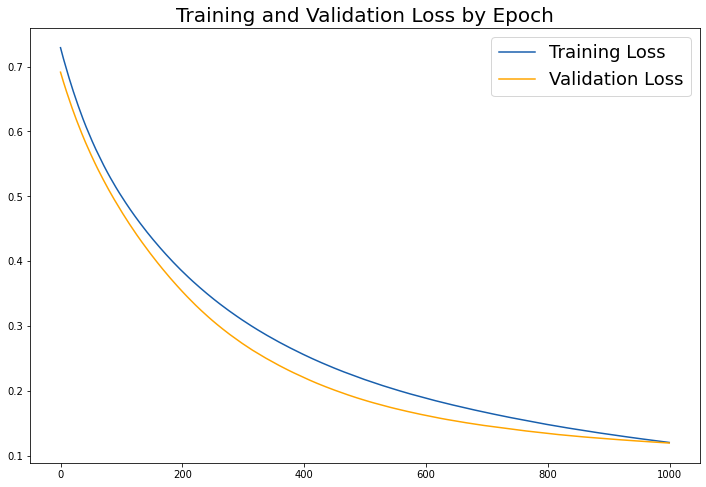

In [39]:
plt.figure(figsize=(12, 8))
# Generate line plot of training, testing loss over epochs.
plt.plot(hist_3.history['loss'], label='Training Loss', color='#185fad')
plt.plot(hist_3.history['val_loss'], label='Validation Loss', color='orange')
# Set title
plt.title('Training and Validation Loss by Epoch', fontsize = 20)
plt.legend(fontsize = 18);

3/3 [==============================] - 0s 5ms/step - loss: 0.1977 - auc_1: 0.9732
test evaluation [0.19765694439411163, 0.973214328289032]


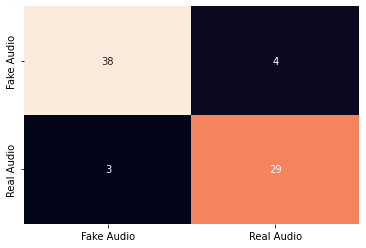

In [40]:
print('test evaluation', model_2.evaluate(X_test_data, y_test))
cm = confusion_matrix(y_test, y_pred=tf.round(model_2.predict(X_test_data)))
ax = sns.heatmap(cm, annot=True, cbar=False)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Fake Audio', 'Real Audio'])
ax.yaxis.set_ticklabels(['Fake Audio', 'Real Audio'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [41]:
predictions_ = X_test.reset_index(drop=True)
predictions_['y_true'] = y_test
pred = np.round(model_2.predict(X_test_data)).reshape(74,)
predictions_['y_pred'] = pred
predictions_[predictions_.y_true != predictions_.y_pred]

,file,y_true,y_pred
0,/content/synthesizer_long_audio_version_withou...,NaN,0.0
1,/content/synthesizer_long_audio_version_withou...,NaN,0.0
2,/content/synthesizer_long_audio_version_withou...,NaN,0.0
3,/content/synthesizer_long_audio_version_withou...,NaN,0.0
4,/content/real_audio/sample-002089.mp3,NaN,1.0
...,...,...,...
68,/content/real_audio/sample-000945.mp3,NaN,1.0
69,/content/synthesizer_long_audio_version_withou...,NaN,0.0
70,/content/synthesizer_long_audio_version_withou...,NaN,0.0
71,/content/real_audio/sample-002767.mp3,NaN,1.0


In [42]:
Audio(predictions_.file[2], autoplay=True)

In [43]:
Audio(predictions_.file[16], autoplay=True)